<a href="https://cognitiveclass.ai"><img src = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/IDSNlogo.png" width = 400> </a>

# Capstone Project - Clustering restaurants in Toronto

<p>This notebook will show, how to find restautant clusters in Toronto based on their ranking and positional information, if present. Rating and positional information are retreived with help of Foursquare Places API. The kMeans Algorithm will be used to indetify those clusters. Since it uses Eucledian distance to determine the similarity between elements, using positional information provided in degrees of latitude and longitude is straight forward. </p>

<p>The result will a Map contianing the different restaurant clusters.</p>

## Table of Contents
1. <a href="#item1"> Get list of Torono's restaurants</a></li>
2. <a href="#item2"> Get restaurant ratings</a></li>
3. <a href="#item3"> Clustering Torono's restaurants</a></li>
4. <a href="#item4"> Cluster analysis </a></li>
5. <a href="#item5"> Conclusion </a></li>

## Imports

In [3]:
import pandas as pd
# don't want truncation of displayed cells
pd.set_option('display.max_colwidth', None)
# show all columns
pd.set_option('display.max_columns', None)

import numpy as np # library to handle data in a vectorized manner

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

%matplotlib inline

print('Libraries imported.')

Libraries imported.


<a id="item1"></a>

# 1. Get list of Torono's restaurants

<p> The first step is to collect all restaurants in Toronto. Therfore Totonto's neigborhoods will be explored for all types of venues with the Forsquare API. The result set will then be filtered to contian restaurants only. </p>

## Get venues per neigborhood

<p>To explore a given neigborhood with Forsqure API its positional information is neede. Luckily there already exists a data collection <em>toronto_neigborhoods.csv</em> containing all neigborhood in Toronto togehter with the needed informarion.</p>

In [4]:
# load the dataset
neighborhoods = pd.read_csv('toronto_neigborhoods.csv')

In [5]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 15 boroughs and 103 neighborhoods.


In [6]:
neighborhoods.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Start utilizing the Foursquare API to explore the neighborhoods and colect all venues

In [7]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


Let's create a function to repeat reteiving vanues to process to all the neighborhoods in Toronto

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
#toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
#                                   latitudes=toronto_data['Latitude'],
#                                   longitudes=toronto_data['Longitude']
#                                  )

In [10]:
# the call to the the FOursquare API is limited for the created account; because of this the qurey was run earlier before.
toronto_venues = pd.read_csv('toronto_venus.csv')

In [11]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,4bb6b9446edc76b0d771311c,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,4c23d3aaf7ced13a5ed7216d,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,4beee041e24d20a1cd857314,RBC Royal Bank,43.766790,-79.191151,Bank
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,4c62f34bde1b2d7fec89e370,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,57fd24f6cd1083addfd77bf9,Sail Sushi,43.765951,-79.191275,Restaurant


## Get resturants per neigborhood

As it can been seen, the returned data does not contain any rating information. This needs to be reteived extra. Also note, that the **Venue Category** column does contain many different categories. 

In [12]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 272 uniques categories.


Show 20 first entries to get an idea.

In [13]:
cat = pd.Series(toronto_venues['Venue Category'].unique())
cat.sort_values(inplace=True)
cat.reset_index(drop=True,inplace=True)
cat.head(20)

0       Accessories Store
1          Adult Boutique
2                 Airport
3      Airport Food Court
4            Airport Gate
5          Airport Lounge
6         Airport Service
7        Airport Terminal
8     American Restaurant
9            Antique Shop
10               Aquarium
11            Art Gallery
12             Art Museum
13    Arts & Crafts Store
14       Asian Restaurant
15     Athletics & Sports
16            Auto Garage
17          Auto Workshop
18              BBQ Joint
19             Baby Store
dtype: object

Lets find all restautrants by seachring for those entries, which contain 'restaurant' in their category.

In [14]:
# find possible categories
restaurant_cat=cat[cat.str.contains('Restaurant')]
restaurant_cat.values

array(['American Restaurant', 'Asian Restaurant', 'Belgian Restaurant',
       'Brazilian Restaurant', 'Cajun / Creole Restaurant',
       'Caribbean Restaurant', 'Chinese Restaurant',
       'Colombian Restaurant', 'Comfort Food Restaurant',
       'Cuban Restaurant', 'Dim Sum Restaurant', 'Doner Restaurant',
       'Dumpling Restaurant', 'Eastern European Restaurant',
       'Ethiopian Restaurant', 'Falafel Restaurant',
       'Fast Food Restaurant', 'Filipino Restaurant', 'French Restaurant',
       'German Restaurant', 'Gluten-free Restaurant', 'Greek Restaurant',
       'Hakka Restaurant', 'Indian Restaurant', 'Italian Restaurant',
       'Japanese Restaurant', 'Korean BBQ Restaurant',
       'Korean Restaurant', 'Latin American Restaurant',
       'Mediterranean Restaurant', 'Mexican Restaurant',
       'Middle Eastern Restaurant', 'Modern European Restaurant',
       'Molecular Gastronomy Restaurant', 'Moroccan Restaurant',
       'New American Restaurant', 'Portuguese Restauran

In [15]:
# find restaurants based on the restaurant category
restaurants=toronto_venues['Venue Category'].isin(restaurant_cat.values)
df_restaurants=toronto_venues[restaurants]
df_restaurants.shape

(479, 8)

There are 479 venues which contain be seen as restaurnat. Lest have a look.

In [16]:
df_restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,4bb6b9446edc76b0d771311c,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,57fd24f6cd1083addfd77bf9,Sail Sushi,43.765951,-79.191275,Restaurant
5,"Guildwood, Morningside, West Hill",43.763573,-79.188711,5411f741498e9ebd5e35d8bd,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant
13,Woburn,43.770992,-79.216917,4de0403ed4c040523ea079f4,Korean Grill House,43.770812,-79.214502,Korean BBQ Restaurant
15,Cedarbrae,43.773136,-79.239476,4b1711a6f964a520cbc123e3,Federick Restaurant,43.774697,-79.241142,Hakka Restaurant


Take a look at the distribution of restautrants by using a scatter plot.

<AxesSubplot:title={'center':'Restaurants in Toronto'}, xlabel='Venue Longitude', ylabel='Venue Latitude'>

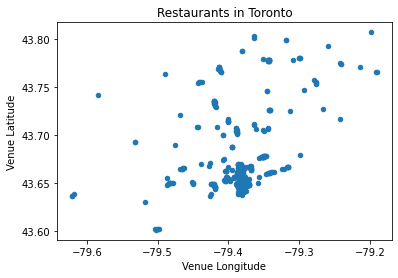

In [17]:
df_restaurants.plot.scatter('Venue Longitude','Venue Latitude',title='Restaurants in Toronto')

<a id="item2"></a>

# 2. Get restaurant rating

Let's create a function to repeat reteiving rating to process to all the restaurants in Toronto.

In [18]:
def getOverallRating(venue_ids):
    
    rating_list=[]
    for venue_id in venue_ids:
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(
            venue_id, 
            CLIENT_ID, 
            CLIENT_SECRET,
            ACCESS_TOKEN, 
            VERSION)

        result = requests.get(url).json()
        rating = 0
        try:
            rating = result['response']['venue']['rating']
            print('Rating for {} is {}'.format(venue_id,str(rating)))
        except:
            print( 'The venue {} has not been rated yet.'.format(venue_id))
                  
        
        # return only relevant information for each nearby venue
        rating_list.append({'Venue id':venue_id,
                            'Rating':rating})

   
    return(rating_list)

In [19]:
#like above, API calls are limited, so we will load results of preceeding calls 
#rating_df = getOverallRating(df_restaurants['Venue id'])
rating_df = pd.read_csv('toronto_ratings.csv',usecols=[1,2])

In [20]:
rating_df.head()

,Venue id,Rating
0,4bb6b9446edc76b0d771311c,6.0
1,57fd24f6cd1083addfd77bf9,0.0
2,5411f741498e9ebd5e35d8bd,0.0
3,4de0403ed4c040523ea079f4,0.0
4,4b1711a6f964a520cbc123e3,7.1


**Note:** A rating of 0.0 means, that the restaurant has not been rated yet.

Take a look at the rating just for curiosity.

<AxesSubplot:ylabel='Frequency'>

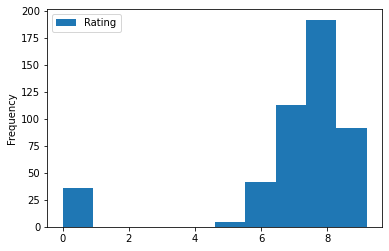

In [21]:
rating_df.plot.hist('Rating')

In [22]:
rating_df[rating_df['Rating']==0].count()

Venue id    36
Rating      36
dtype: int64

There are 36 unrated restaurants. They will be removed from the restaurant list before clustering.

In [23]:
rating_freq_df = rating_df
rating_freq_df = rating_freq_df.groupby(['Rating']).count()
rating_freq_df.sort_index(ascending=False,inplace=True)
rating_freq_df.head(20)

,Venue id
Rating,
9.2,1
9.1,1
9.0,3
8.9,4
8.8,4
8.7,12
8.6,12
8.5,9
8.4,16


The following steps create the final data set used for cluster analysis.

In [24]:
#create temoryty result set
res = pd.concat([df_restaurants.set_index('Venue id'),rating_df.set_index('Venue id')], axis=1, join='inner').reset_index()

# remove all restaurants with have not been rated
res = res[res['Rating']!=0.0]

# data frame containing the rated restaurants
df_restaurants_rated = res
df_restaurants_rated.head()

,Venue id,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Rating
0,4bb6b9446edc76b0d771311c,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant,6.0
4,4b1711a6f964a520cbc123e3,Cedarbrae,43.773136,-79.239476,Federick Restaurant,43.774697,-79.241142,Hakka Restaurant,7.1
5,4e261f261f6eb1ae13930699,Cedarbrae,43.773136,-79.239476,Drupati's Roti & Doubles,43.775222,-79.241678,Caribbean Restaurant,7.0
6,4c27da423492a593158cb628,Cedarbrae,43.773136,-79.239476,Thai One On,43.774468,-79.241268,Thai Restaurant,6.6
9,4b6475aef964a520eab42ae3,"Dorset Park, Wexford Heights, Scarborough Town Centre",43.757410,-79.273304,Kim Kim restaurant,43.753833,-79.276611,Chinese Restaurant,7.1


In [25]:
df_restaurants_rated.shape

(443, 9)

Lets see how the final data set looks like using a scatter plot.

Text(0.5, 1.0, 'Rated Restaurants in Toronto')

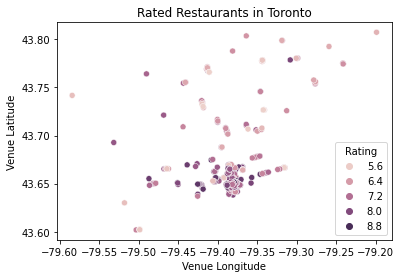

In [26]:
ax = sns.scatterplot(data=df_restaurants_rated, x='Venue Longitude', y='Venue Latitude', hue='Rating')
ax.set_title('Rated Restaurants in Toronto')

<a id="item3"></a>

# 3. Clustering Torono's restaurants

Now it's time to cluster the restaurants with help of k-Means Algorithm.

In [27]:
# define feature matrix
X= df_restaurants_rated[['Venue Longitude','Venue Latitude','Rating']]
X.head()

,Venue Longitude,Venue Latitude,Rating
0,-79.199056,43.807448,6.0
4,-79.241142,43.774697,7.1
5,-79.241678,43.775222,7.0
6,-79.241268,43.774468,6.6
9,-79.276611,43.753833,7.1


Now let's normalize the dataset. But why do we need normalization in the first place? Normalization is a statistical method that helps mathematical-based algorithms interpret features with different magnitudes and distributions equally. We use **StandardScaler()** to normalize our dataset.


In [28]:
cluster_dataset = StandardScaler().fit_transform(X)

kMeans need to be passed in the number of clusters. But how do you find the optimal number of them? With help of the **elbow method** the number of clusters can be determined grafically.

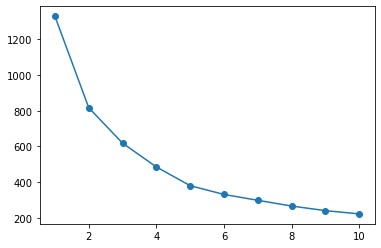

In [29]:
distorsions = []
for i in range (1,11):
    km = KMeans(n_clusters = i,init='k-means++',n_init=10,max_iter=300,random_state=0)
    km.fit(cluster_dataset)
    distorsions.append(km.inertia_)

plt.plot(range(1,11),distorsions,marker='o')
plt.show()

It looks lieke 5 is a good choice for the number of clusters.

In [30]:
# create the algorithm object and dertermine clsuters
kmeans = KMeans(n_clusters=5, random_state=0).fit(cluster_dataset)

In [31]:
cluster_data = pd.DataFrame(cluster_dataset)
cluster_data.head()

,0,1,2
0,4.780358,3.479960,-2.017960
1,3.693484,2.640431,-0.592399
2,3.679663,2.653902,-0.721996
3,3.690233,2.634562,-1.240382
4,2.777518,2.105629,-0.592399


In [34]:
# create result data frame
df_restaurants_rated.insert(0, 'Cluster Labels', kmeans.labels_)
df_restaurants_rated.head()

,Cluster Labels,Venue id,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Rating
0,1,4bb6b9446edc76b0d771311c,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant,6.0
4,1,4b1711a6f964a520cbc123e3,Cedarbrae,43.773136,-79.239476,Federick Restaurant,43.774697,-79.241142,Hakka Restaurant,7.1
5,1,4e261f261f6eb1ae13930699,Cedarbrae,43.773136,-79.239476,Drupati's Roti & Doubles,43.775222,-79.241678,Caribbean Restaurant,7.0
6,1,4c27da423492a593158cb628,Cedarbrae,43.773136,-79.239476,Thai One On,43.774468,-79.241268,Thai Restaurant,6.6
9,1,4b6475aef964a520eab42ae3,"Dorset Park, Wexford Heights, Scarborough Town Centre",43.757410,-79.273304,Kim Kim restaurant,43.753833,-79.276611,Chinese Restaurant,7.1


<a id="item4"></a>

# 4. Cluster analysis

Lets have a closer look at the culster.

In [35]:
result_ = df_restaurants_rated.groupby('Cluster Labels').mean().reset_index()

Display the average rating per cluster

In [36]:
result_[['Cluster Labels', 'Rating']].sort_values(by='Rating',ascending=False)

,Cluster Labels,Rating
4,4,8.314907
0,0,7.352128
2,2,6.820000
3,3,6.752778
1,1,6.510526


How many restautants are contained in the different clusters?

In [37]:
temp = df_restaurants_rated.groupby('Cluster Labels').count()
temp['Venue']

Cluster Labels
0    188
1     38
2     20
3     36
4    161
Name: Venue, dtype: int64

Define a desribe() function for the clusters like the one existing for Pandas DataFrames

In [38]:
cluster_dataframes = df_restaurants_rated[['Cluster Labels','Rating']]
info=[]
for i in range(0,5):
    cluster = cluster_dataframes[cluster_dataframes['Cluster Labels']==i]
    rating_description = cluster['Rating'].describe()
    info.append({'Cluster Label':i,
                 'Num of elements':round(rating_description['count'],2),
                 'Mean Rating':round(rating_description['mean'],2),
                 'Std Deviation':round(rating_description['std'],2),
                 'Max Rating':round(rating_description['max'],2),
                 'Min Rating':round(rating_description['min'],2),
                 '25%': round(rating_description['25%'],2),
                 '50%': round(rating_description['50%'],2),
                 '75%': round(rating_description['75%'],2)})

info_df = pd.DataFrame(info)
 

In [40]:
info_df

,Cluster Label,Num of elements,Mean Rating,Std Deviation,Max Rating,Min Rating,25%,50%,75%
0,0,188.0,7.35,0.41,8.0,5.7,7.20,7.50,7.62
1,1,38.0,6.51,0.69,8.1,5.5,6.00,6.35,7.00
2,2,20.0,6.82,0.77,8.3,5.7,6.10,7.00,7.30
3,3,36.0,6.75,0.61,8.3,5.5,6.38,6.75,7.30
4,4,161.0,8.31,0.29,9.2,7.8,8.10,8.30,8.50


<p>The above table give a mor detailed insight into the clusters. Although all of them contain at least one restaurant with high rating (max. rating above 8) the mean ratings are not so good, except for cluster 4 with an mean value of 8.31.</p>
The next section will show where these restaurants are located.

<a id="item5"></a>

# 5. Conclusion

Display the different cluster on a map to visually identify the clusters and find the spots of high rated restaurants.

In [57]:
address = 'Toronto, Canada'

#Use geopy library to get the latitude and longitude values of Toronto
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11,zoom_control=True, scrollWheelZoom=False, dragging=True)
#kclusters = clusterNum
kclusters=5

# create map
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = {}
for lat, lon, cluster, rating, venue in zip( 
                    df_restaurants_rated['Venue Latitude'], 
                    df_restaurants_rated['Venue Longitude'], 
                    df_restaurants_rated['Cluster Labels'], 
                    df_restaurants_rated['Rating'],
                    df_restaurants_rated['Venue']):
    label = folium.Popup(str(venue) + '\nRating: ' + str(rating) +  '\nCluster'+ str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto)  
    markers_colors[cluster]= rainbow[cluster-1]


    
  
legend_html = """
<div style="position:fixed;
     bottom: 60px; 
     left: 600px; 
     width: 250px; 
     height: 150px; 
     border:2px solid grey;
     z-index: 9999;
     font-size:14px;">
     &nbsp;<b>Clusters:</b><br>
     &nbsp;<i class="fa fa-circle fa-1x" style="color:#ff0000"></i> Cluster 0; Mean Rating: 7.35<br>
     &nbsp;<i class="fa fa-circle fa-1x" style="color:#8000ff"></i> Cluster 1; Mean Rating: 6.51<br>
     &nbsp;<i class="fa fa-circle fa-1x" style="color:#00b5eb"></i> Cluster 2; Mean Rating: 6.82<br>
     &nbsp;<i class="fa fa-circle fa-1x" style="color:#80ffb4"></i> Cluster 3; Mean Rating: 6.75<br>
     &nbsp;<i class="fa fa-circle fa-1x" style="color:#ffb360"></i> Cluster 4; Mean Rating: 8.31<br>
     
</div>"""
    
# Add Legend
map_toronto.get_root().html.add_child(folium.Element(legend_html))

#save map
#map_toronto.save('toronto_restaurant_clusters.html')
    
map_toronto

The map shows, that the clustering has been successfull. Except for clusters 0 and 4 the clusters are cleary separated. There is an area on the map, where lot of frestaurants seem to be centered , in the middle of Toronto. 

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                           |
| ----------------- | ------- | ------------- | -------------------------------------------- |
| 2021-05-03        | 1.0     | D. M. E       | Initial version                              |
|                   |         |               |                                              |


In [58]:
map_toronto.save('toronto_restaurant_clusters.html')

In [ ]:
map_toronto